# Chapter 3 - Classification

In [24]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib as mpl
import matplotlib.pyplot as plt

## MNIST

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

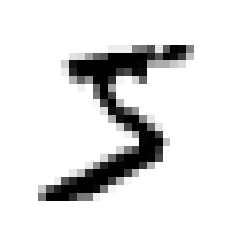

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

We are able to take the 784 different features of each image and reshape into a 28x28 array to print out the image. We can than see the label with the 'y' value.

In [7]:
y[0]

'5'

Currently the lable is a string, but we can cast 'y' to integers:

In [8]:
y = y.astype(np.uint8)

But before moving further along we should split the data into a training set (first 60,000 images) and test set (last 10,000 images).

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let's make the problem smaller and focus only on one number

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use the SGDClassifier to detect images of the number 5:

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

#### Mearusing Accurasy Using Cross-Validation

In [13]:
# StraitfiedKFold class performs a stratisfied sampling
# At each iteration the code creates a clone of the classifier
# Trains that clone on the training folds
# And makes predictions on the test fold

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\Users\jaola\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


Now we can use the `cross_val_score()` to evalueate the `SDGClassifier` model using K-fold cross-validation

In [14]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

We get an accuraci rating of above 95% with thsi classifier, but let's see how well we do with a 'dumb' classifier that classifies every single image in the "not-5" class:

In [15]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This has over 90% accuracy simply because about 10% of the images are 5s, so if you always guess *not* a 5, you will be correct about 90% of the time.

#### Confusion Matrix

The *Confusion Matrix* counts how often an instance of class A is classified as class B.

First we need a set of predictions to compare to the actual targets. We don't want to use the test set for this (we only want to use it at the very end of the project). Instead we can use the `cross_val_predict()` function

In [17]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

The top row is all non-5 images, with the correcly predicted ones on the left (53892) and images wrongly classified as 5 on the right (687). The second row has false negatives on the left (1891) and correctly identified 5s (*true positives*) on the right (3530).

We can show how a perfect classifier gives back the confusion matrix by pretending that we have reach perfection:

In [19]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### Precision and Recall

In [21]:
precision_score(y_train_5, y_train_pred) #percentage of images represented as 5s were of 5s

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred) #percentage of times the program identifies the image as a 5 it is correct

0.6511713705958311

The F1 score combines the two scores, `2*((precision*recall)/(precision+recall))`.

This score is not always a good indicator of your predictions, as somethimes you don't mind a low recall rate but need to achieve a high precision (Identifying kid friendly videos on youtube), and other times you need it to be the other way around (security guards don't mind getting false alerts but want to catch all shoplifters). Unfortunately, we can not have it both ways. Increasing the precision decreases the recall, and vice cv

In [25]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846